<a href="https://colab.research.google.com/github/pablillo77/nlp_and_deep_learning/blob/main/DS_NLP_DeepLearning_Final_Pablo_Gim%C3%A9nez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b> 🎬 Introduction 🎬</b></div>

## Presentation ##
The present project is based on a Kaggle dataset about BBC articles. The objective is to train and produce an algorithm for accurate news classification into five categories, that could yield commericial applications, customizing user engagement and giving insights for targeted audiences.

## Audience ##

This includes both readers seeking relevant content and businesses interested in market research, who could use categorized news for industry insights.

## Comercial Context ##

Personalized content delivery could improve user satisfaction and time spent on the platform. The classified data could also be valuable to marketing advertisers for audience targeting.

## Key Hypotheses and Questions ##

- Effective categorization and personalized news recommendations enhance reader engagement and retention.
- How the categories are distributed?
- Can we predict categories in new content?

## Objectives ##

- Produce an accurate classification model using LSTM and or RNN.
- Acquire category-based insights.
- Set the bases for future work on trending category predictions.





<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🧹 Preliminary data cleaning 🧹</b></div>

 </b></div>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>⏳Libraries imports and data upload⏳
 </b></div>

In [4]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
import random


from collections import Counter
from wordcloud import WordCloud

# Sklearn mainly for model evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


# Tensorflow for creating and LSTM model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [5]:
#dataset load from github

url = 'https://raw.githubusercontent.com/pablillo77/nlp_and_deep_learning/refs/heads/main/bbc_text_cls.csv'
df = pd.read_csv(url)
df.shape

(2225, 2)

In [6]:
#Some quick checks

pd.set_option('display.max_colwidth',None)
print("Data shape: ",df.shape)
print("Data types: ",df.dtypes)
df.sample(2)

Data shape:  (2225, 2)
Data types:  text      object
labels    object
dtype: object


,text,labels
1390,"Butler strikes gold in Spain\n\nBritain's Kathy Butler continued her impressive year with victory in Sunday's 25th Cross Internacional de Venta de Banos in Spain.\n\nThe Scot, who led GB to World Cross Country bronze earlier this year, moved away from the field with Ines Monteiro halfway into the 6.6km race. She then shrugged off her Portuguese rival to win in 20 minutes 38 seconds. Meanwhile, Briton Karl Keska battled bravely to finish seventh in the men's 10.6km race in a time of 31:41. Kenenisa Bekele of Ethiopia - the reigning world long and short course champion - was never troubled by any of the opposition, winning leisurely in 30.26. Butler said of her success: ""I felt great throughout the race and hope this is a good beginning for a marvellous 2005 season for me."" Elsewhere, Abebe Dinkessa of Ethiopia won the Brussels IAAF cross-country race on Sunday, completing the 10,500m course in 33.22. Gelete Burka then crowned a great day for Ethiopia by claiming victory in the women's race.",sport
475,"Saudi NCCI's shares soar\n\nShares in Saudi Arabia's National Company for Cooperative Insurance (NCCI) soared on their first day of trading in Riyadh.\n\nThey were trading 84% above the offer price on Monday, changing hands at 372 riyals ($99; £53) after topping 400 early in the day. Demand for the insurer's debut shares was strong - 12 times what was on sale. The listing was part of the country's plans to open up its insurance market and boost demand in the sector. Deregulation is expected to boost demand for accident and damage cover.\n\nPreviously, only NCCI has been legally allowed to offer insurance products within Saudi Arabia. However, the authorities have turned a blind eye to the many other firms selling insurance. Saudi Arabia now wants a fully functioning insurance industry and is introducing legislation that will clamp down on unauthorised companies. Policy-makers also want to make having insurance more of a requirement, but first have to take steps to boost public confidence in the system, analysts said. As a result, NCCI is being developed as the industry's flagship firm - publicly-listed, with audited accounts. Saudi Arabia sold 7 million NCCI shares, or about 70% of the company's total capital last month. More than 800,000 applicants got 9 shares each for 205 riyals apiece.",business


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* We can appreciate the dataset has 2 columns, text and labels, consiting of 2225 entries. The data types are objects, "text" will be converted to string for further processing, and the labels will be encoded.
* In the random sample we see numbers, speciall chars such as new line characters that do not add value to the categorization, stop words and capital letters.

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🧹 Data preliminary cleanup 🧹</b></div>

In [7]:
df['text'] = df['text'].astype(str)	 # Convert to string before regex
df['text'] = df['text'].str.lower() # Conversion to lowercase

df['text'] = (
    df['text']
    .str.replace(r'\d+', '', regex=True)           # Remove digits
    .str.replace(r'[^\w\s]', '', regex=True)        # Remove special characters except for word chars and whitespace
    .str.replace(r'\n', ' ', regex=True)            # Replace newlines with space
    .str.replace(r'\\', '', regex=True)             # Remove any remaining backslashes
    .str.replace(r'"', '', regex=True)              # Remove double quotes
    .str.strip()                                    # Trim leading/trailing whitespace
)




<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🔎 Exploratory Data Analysis (EDA).🔎</b></div>

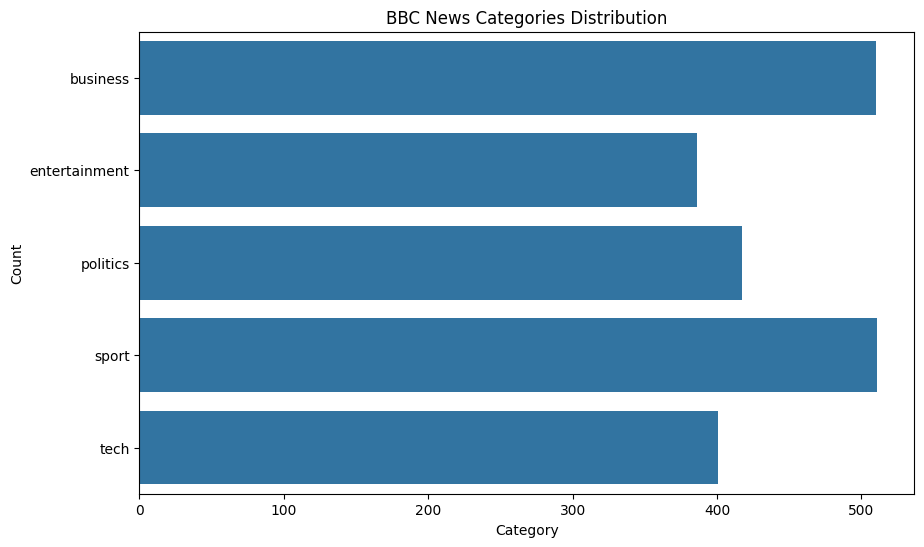

In [8]:
# Check categories distribution

plt.figure(figsize=(10, 6))
sns.countplot(y='labels', data=df)
plt.title(f'BBC News Categories Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


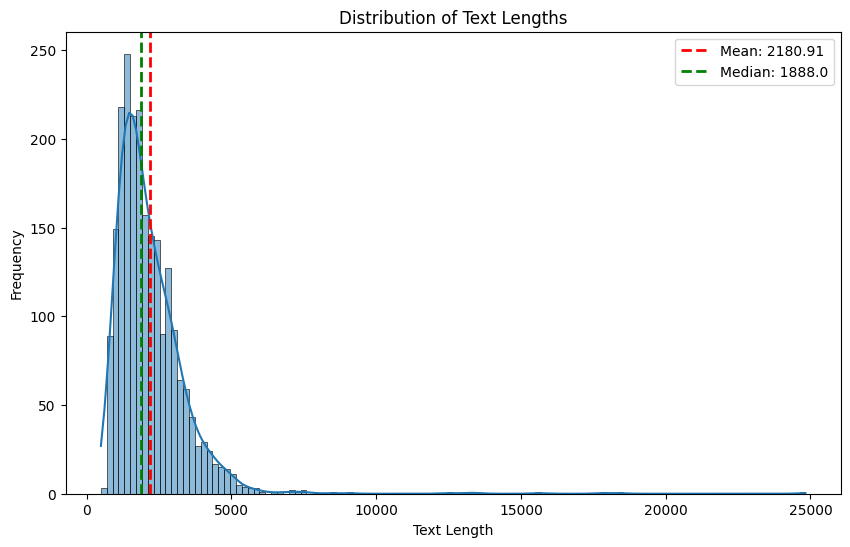

In [9]:
# Checking Text lenghts

df['text_length'] = df['text'].apply(len) # create a new column

mean_length = df['text_length'].mean()
median_length = df['text_length'].median()

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_length}')

plt.legend()
plt.show()

In [10]:
# Find the longest text element and its length

longest_text = df['text'].iloc[df['text'].str.len().idxmax()]
longest_text_length = len(longest_text)

print(f"Longest text element:\n{longest_text}\n")
print(f"Character count: {longest_text_length}")

Longest text element:
terror powers expose tyranny  the lord chancellor has defended government plans to introduce control orders to keep foreign and british terrorist suspects under house arrest where there isnt enough evidence to put them on trial  lord falconer insists that the proposals do not equate to a police state and strike a balance between protecting the public against the threat of terrorism and upholding civil liberties but thriller writer frederick forsyth tells bbc news of his personal response to the move    there is a mortal danger aimed at the heart of britain or so says home secretary charles clarke my reaction so what it is not that i am cynical or just do not care i care about this country very much  but in the  years that i have been alive there has not been one hour of one day of one month of one year when there has not been a threat aimed at us my point is the british have always coped without becoming a dictatorship we have coped with fear without becoming a st

In [11]:
# Stopwords removal

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)


df['text']=df['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


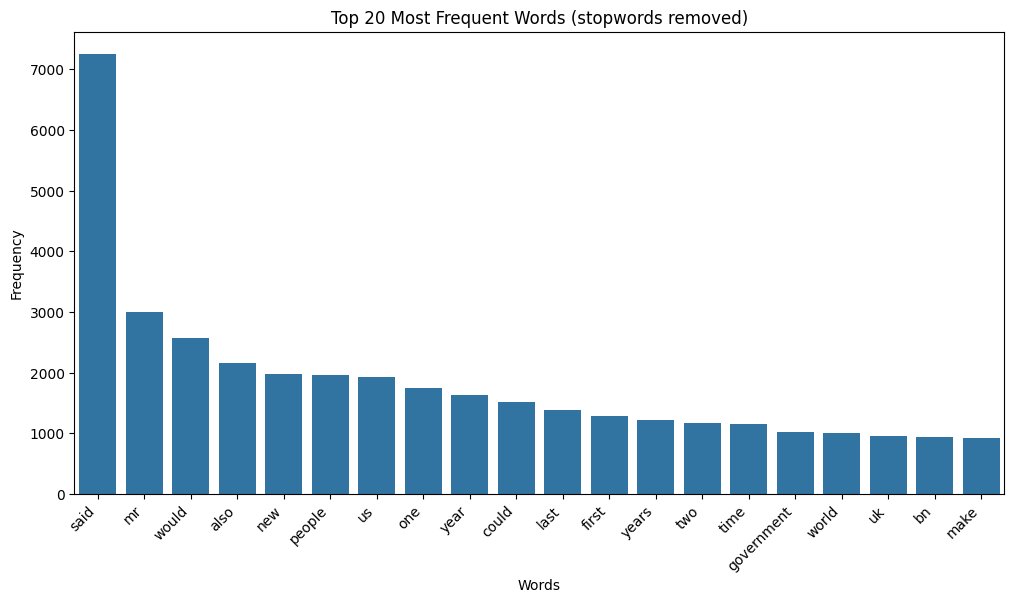

In [12]:
# Counting most frequent words

word_counts = Counter(" ".join(df['text']).split()) #from collections lib
top_20_words = word_counts.most_common(20)

# Extract words and counts for plotting

words, counts = zip(*top_20_words)

# Create the countplot

plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words (stopwords removed)')
plt.show()

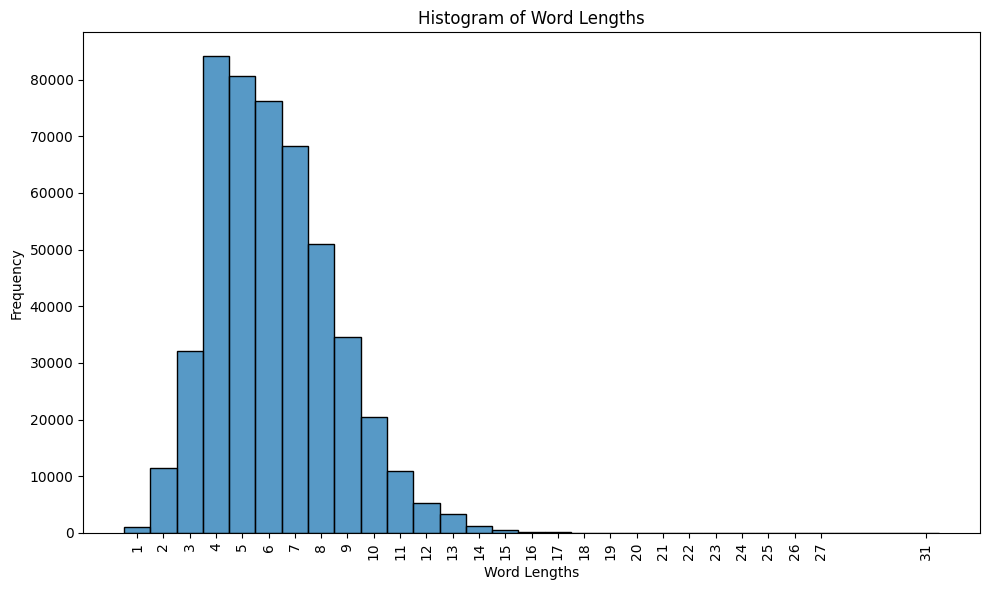

In [17]:
# Words lengths histogram

word_lengths = []
for text in df['text']:
    words = text.split()
    for word in words:
        word_lengths.append(len(word))

unique_word_lengths = sorted(list(set(word_lengths)))

plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, discrete=True)
plt.xticks(unique_word_lengths, rotation=90)
plt.xlabel('Word Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of Word Lengths')
plt.tight_layout()
plt.show()

In [18]:
# Unique word count analysis, for later use in creating a model

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# Fit the text column into a BoW matrix
matrix_bow = vectorizer.fit_transform(df["text"])

# Generated vocabulary
vocabulary  = vectorizer.get_feature_names_out()

unique_word_count = len(np.unique(vocabulary ))

print(f"Number of unique words: {unique_word_count}")

Number of unique words: 31386


In [19]:
# N-grams analysis

from nltk import ngrams


def analyze_ngrams(df, column_name, n=2):
    all_ngrams = []
    for text in df[column_name]:
        # Tokenize the text
        tokens = nltk.word_tokenize(str(text).lower())  # Convert to lowercase

        # Generate n-grams
        text_ngrams = list(ngrams(tokens, n))

        # Extend the list of all n-grams
        all_ngrams.extend(text_ngrams)

    # Count the frequency of each n-gram
    ngram_counts = Counter(all_ngrams)

    # Print or return the most frequent n-grams
    print(f"Top 10 most frequent {n}-grams:\n")
    for ngram, count in ngram_counts.most_common(10):
        print(f"{ngram}: {count}")


analyze_ngrams(df, 'text', n=2)  # Analyze bigrams
print("\n")
analyze_ngrams(df, 'text', n=3)  # Analyze trigrams
print("\n")
analyze_ngrams(df, 'text', n=4)  # Analyze 4grams

Top 10 most frequent 2-grams:

('last', 'year'): 384
('said', 'mr'): 359
('told', 'bbc'): 348
('mr', 'blair'): 296
('prime', 'minister'): 274
('mr', 'brown'): 214
('chief', 'executive'): 198
('said', 'would'): 192
('bbc', 'news'): 178
('general', 'election'): 172


Top 10 most frequent 3-grams:

('told', 'bbc', 'news'): 147
('bbc', 'news', 'website'): 94
('told', 'bbc', 'radio'): 76
('leader', 'michael', 'howard'): 55
('mr', 'blair', 'said'): 54
('million', 'dollar', 'baby'): 50
('radio', 'today', 'programme'): 49
('told', 'bbc', 'sport'): 48
('bbc', 'radio', 'today'): 47
('tory', 'leader', 'michael'): 41


Top 10 most frequent 4-grams:

('told', 'bbc', 'news', 'website'): 77
('bbc', 'radio', 'today', 'programme'): 44
('told', 'bbc', 'radio', 'today'): 39
('tory', 'leader', 'michael', 'howard'): 38
('prime', 'minister', 'tony', 'blair'): 26
('foreign', 'secretary', 'jack', 'straw'): 22
('home', 'secretary', 'charles', 'clarke'): 21
('bbc', 'radio', 'five', 'live'): 18
('shadow', 'chanc

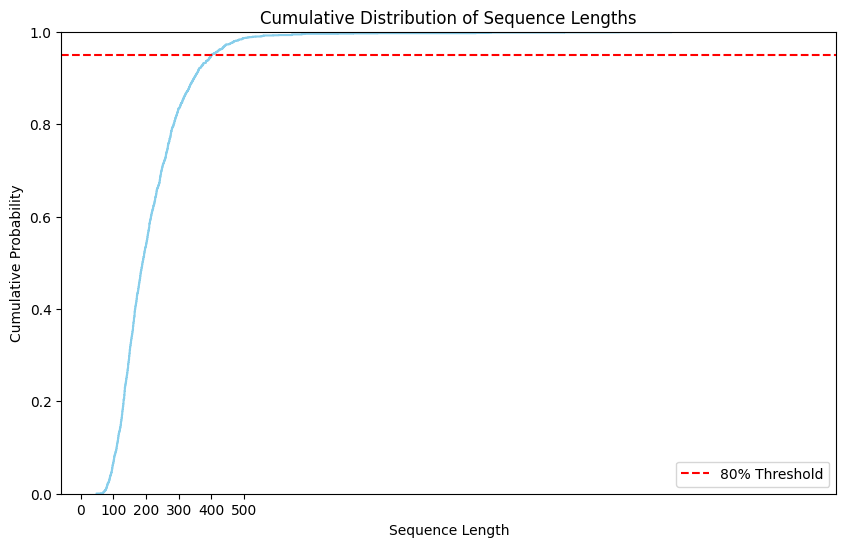

In [20]:
#Study the distribution of sequence lengths

# Prepare text data
texts = df['text'].values

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Create a DataFrame for easier analysis
lengths_df = pd.DataFrame(sequence_lengths, columns=['length'])

# Plot the cumulative distribution of sequence lengths using Seaborn
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=lengths_df, x='length', color='skyblue')
plt.xlabel('Sequence Length')
plt.xticks(range(0, 600, 100))
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Sequence Lengths')
plt.axhline(y=0.95, color='red', linestyle='--', label='80% Threshold')
plt.legend()
plt.show()



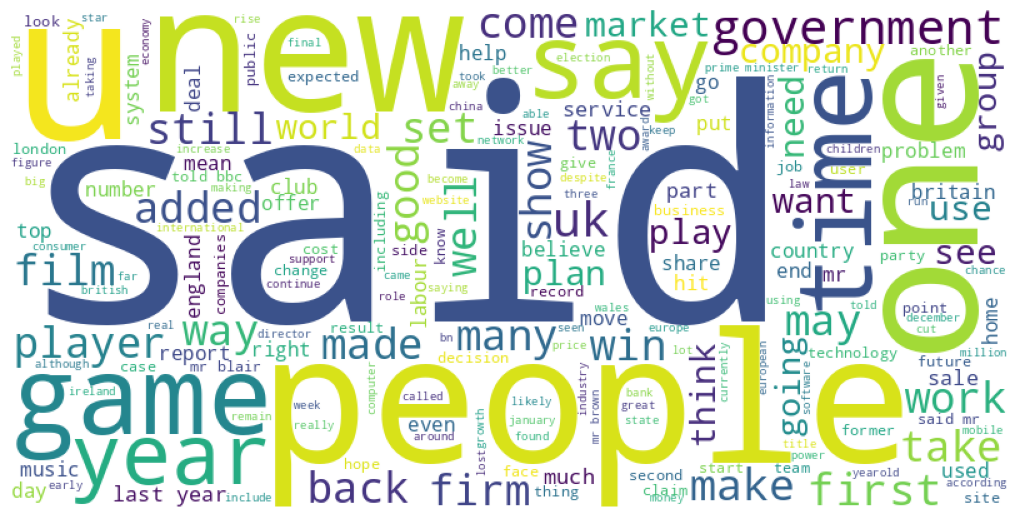

In [21]:
# Create the word cloud

text = " ".join(text for text in df['text'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* The categories (labels) have a good classes balance in the dataset.
* Text lenght analysis, shows a distribution with a mean value of 218 characters, the longest text has 24829.
* Most frequent words are "said" and "mr", "would", consisten with the reporting tone and style of a news channel.
* The word lenghts analysis, indicates that having removed the stopwords (usually words of 2 or 3 letters if language is English) the next most frequent lengths are 4 and 5 letters long. Again there is agreement with the language used.
* We found 31386 different and unique words.
* N-Grams study shows context also in agreemnent with the reporting style of a news channel. "last year", "told BBC news" and "told BBC nwes website" are the most frequent for bigrams, trigrams and four-grams.
* Sequence Length cumulative distribution, indicates that selecting in further processing 300 as sequence length, would cover roughly 95% of length cases.

<a id="1"></a>
## <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🧠 Models 🧠</b></div>

## <b>Functions definitions</b>

In [22]:
# Define a plotting Losses curves

def plot_training_history(model):
  """Plots the training and validation loss from a Keras model's history.

  Args:
    model: A trained Keras model with a history attribute.
  """
  plt.figure(figsize=(10, 6))
  plt.plot(model.history.history['loss'], label='Training Loss')
  plt.plot(model.history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

## <b>Feature selection and encoding</b>

In [23]:
# Prepare text data and labels
X = df['text'].values
y = df['labels'].values #target variable

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



## <b>Data split, tokenization and padding</b>

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train = pd.Series(X_train)
X_test = pd.Series(X_test)

# Tokenization and padding
max_words = 20000  # Number of unique words to use
max_length = 300  # Maximum length of input sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

## <b>Building and compiling the models</b>

In [27]:
# LSTM model

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
# Training the model 1
model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.2164 - loss: 1.5986 - val_accuracy: 0.4663 - val_loss: 1.3718
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.4811 - loss: 1.1415 - val_accuracy: 0.6826 - val_loss: 0.8007
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.8086 - loss: 0.5222 - val_accuracy: 0.7079 - val_loss: 0.7047
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 377ms/step - accuracy: 0.9132 - loss: 0.3297 - val_accuracy: 0.8848 - val_loss: 0.3803
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - accuracy: 0.9888 - loss: 0.1162 - val_accuracy: 0.9242 - val_loss: 0.2658
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.9893 - loss: 0.0772 - val_accuracy: 0.8792 - val_loss: 0.3885
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - accuracy: 0.9961 - loss: 0.0635 - val_accuracy: 0.8848 - val_loss: 0.3328
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 340ms/step - accuracy: 0.9969 - loss: 0.0501 - val_accu

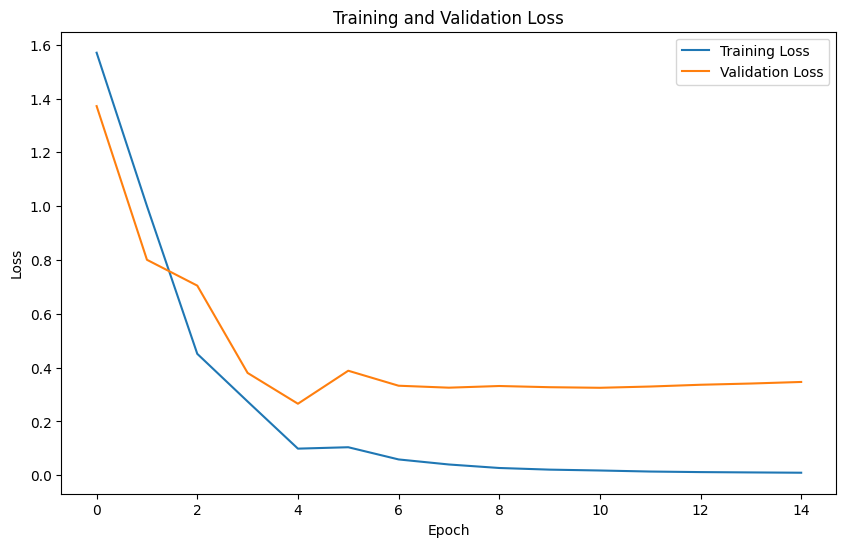

In [30]:
# Plotting the loss function for training and validation sets

plt.figure(figsize=(10, 6))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* The model shows overfitting tendency, it is learning very well training data, but after epoch 5, validation loss starts to slightly increase.

In [31]:
# LSTM model2
from tensorflow.keras.layers import GRU

model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(GRU(32))
model2.add(Dropout(0.2))
model2.add(Dense(len(label_encoder.classes_), activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau

# Crear el callback para reducir el learning rate cuando la validación no mejora
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Entrenar el modelo con el callback
#model2.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler])
model2.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 515ms/step - accuracy: 0.2505 - loss: 1.5919 - val_accuracy: 0.5674 - val_loss: 1.2971
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 471ms/step - accuracy: 0.7036 - loss: 0.9534 - val_accuracy: 0.8399 - val_loss: 0.4988
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 432ms/step - accuracy: 0.9197 - loss: 0.2524 - val_accuracy: 0.9242 - val_loss: 0.2569
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - accuracy: 0.9892 - loss: 0.0732 - val_accuracy: 0.9326 - val_loss: 0.2087
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 420ms/step - accuracy: 0.9945 - loss: 0.0384 - val_accuracy: 0.9466 - val_loss: 0.1971
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step - accuracy: 0.9978 - loss: 0.0197 - val_accuracy: 0.9494 - val_loss: 0.1895
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9983 - loss: 0.0201 - val_accuracy: 0.9466 - val_loss: 0.1830
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - accuracy: 0.9999 - loss: 0.0086 - val_accu

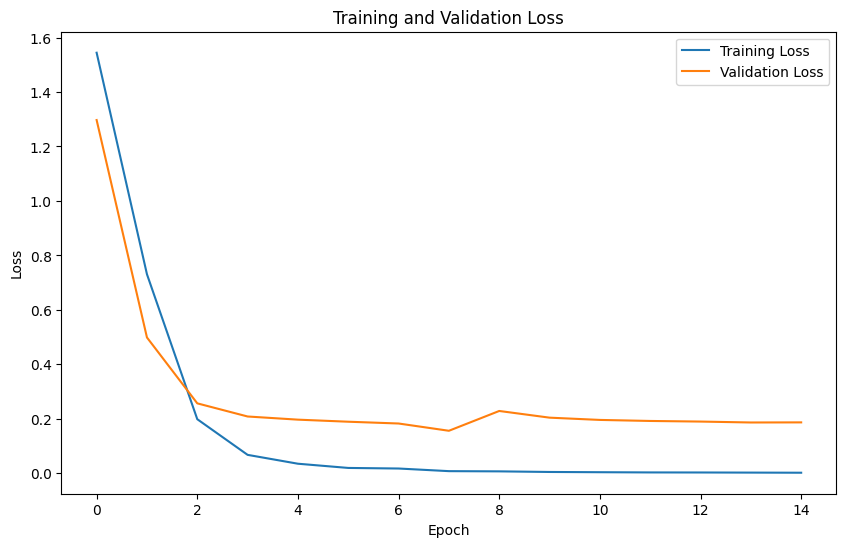

In [33]:
plot_training_history(model2)

In [ ]:
# Predicting on test data
y_test_predictions = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_predictions, axis=1)

# Calculate metrics for test data
accuracy = accuracy_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_test_pred_classes, average='macro')
recall = recall_score(y_test, y_test_pred_classes, average='macro')
f1 = f1_score(y_test, y_test_pred_classes, average='macro')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [ ]:
def calculate_metrics(model, X_test_padded, y_test):
  """
  Predicts on test data and calculates accuracy, precision, recall, and F1 score.

  Args:
    model: The trained model.
    X_test_padded: Padded test data.
    y_test: True labels for the test data.

  Returns:
    A dictionary containing the calculated metrics.
  """
  y_test_predictions = model.predict(X_test_padded)
  y_test_pred_classes = np.argmax(y_test_predictions, axis=1)

  accuracy = accuracy_score(y_test, y_test_pred_classes)
  precision = precision_score(y_test, y_test_pred_classes, average='macro')
  recall = recall_score(y_test, y_test_pred_classes, average='macro')
  f1 = f1_score(y_test, y_test_pred_classes, average='macro')

  return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1
  }

In [ ]:
# Display results
results = pd.DataFrame({
    'model': ['LSTM'],
    'precision': [precision],
    'recall': [recall],
    'F1': [f1],
    'accuracy': [accuracy]
})
print("Test Results:")
print(results)

Test Results:
  model  precision    recall        F1  accuracy
0  LSTM   0.882497  0.881208  0.879328  0.878652


In [ ]:
# prompt: convert to function for evaluating more than one model:
# results = pd.DataFrame({
#     'model': ['LSTM'],
#     'precision': [precision],
#     'recall': [recall],
#     'F1': [f1],
#     'accuracy': [accuracy]
# })
# print("Test Results:")
# print(results)

def evaluate_models(models, X_test_padded, y_test):
  """
  Evaluates multiple models and returns a DataFrame with their performance metrics.

  Args:
    models: A dictionary where keys are model names and values are trained models.
    X_test_padded: Padded test data.
    y_test: True labels for the test data.

  Returns:
    A pandas DataFrame containing the evaluation results.
  """

  results_data = []
  for model_name, model in models.items():
    metrics = calculate_metrics(model, X_test_padded, y_test)
    results_data.append({
        'model': model_name,
        'precision': metrics["precision"],
        'recall': metrics["recall"],
        'F1': metrics["f1"],
        'accuracy': metrics["accuracy"]
    })

  results_df = pd.DataFrame(results_data)
  return results_df



In [ ]:
# Example usage (assuming you have trained models 'model' and 'model2'):
models_to_evaluate = {
    'LSTM': model,
    'LSTM_with_LR_Scheduler': model2,
    # Add more models here as needed
}
results = evaluate_models(models_to_evaluate, X_test_padded, y_test)
print("Test Results:")
results

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test Results:


,model,precision,recall,F1,accuracy
0,LSTM,0.858959,0.857991,0.857732,0.862921
1,LSTM_with_LR_Scheduler,0.875450,0.881195,0.876992,0.883146


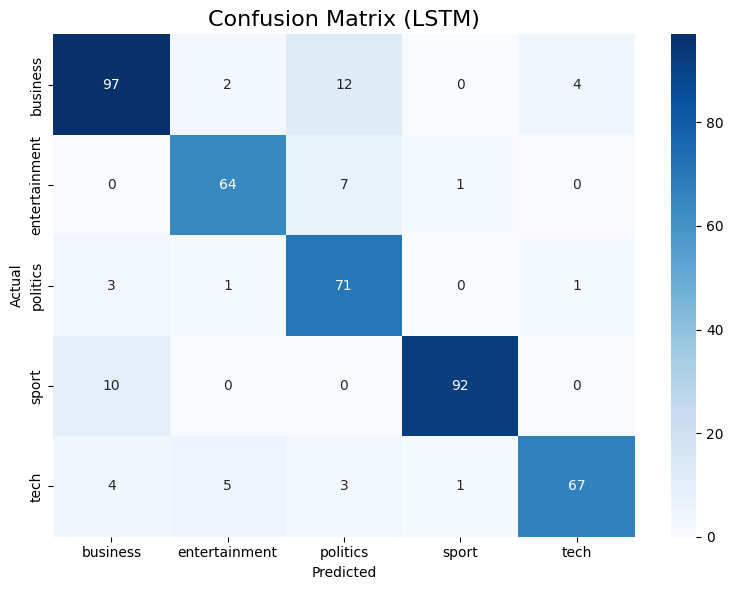

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion Matrix (LSTM)', fontsize=16)
ax.xaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.yaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
# Predicting on test data
y_test_predictions = model2.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_predictions, axis=1)

# Calculate metrics for test data
accuracy = accuracy_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_test_pred_classes, average='macro')
recall = recall_score(y_test, y_test_pred_classes, average='macro')
f1 = f1_score(y_test, y_test_pred_classes, average='macro')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


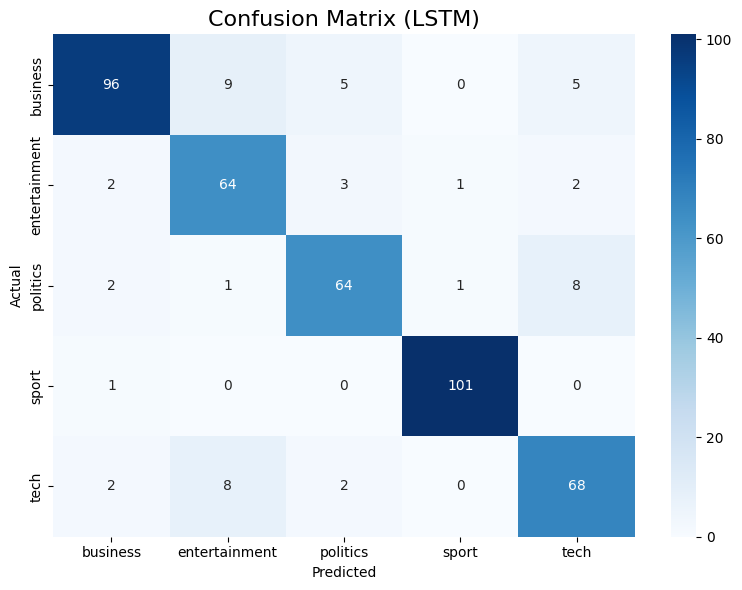

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion Matrix (LSTM)', fontsize=16)
ax.xaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.yaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
# prompt: test the model randomly selecting 3 values, sow the prediction and the actual value

# Select 3 random indices from the test data
random_indices = random.sample(range(len(X_test)), 5)

# Loop through the selected indices
for index in random_indices:
    # Get the text and true label
    text = X_test.iloc[index]
    true_label = y_test[index]

    # Preprocess the text for prediction
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)

    # Predict the category
    prediction = model.predict(text_padded)
    predicted_label = np.argmax(prediction)

    # Decode the predicted label
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]
    true_category = label_encoder.inverse_transform([true_label])[0]

    # Print the results
    print(f"Text: {text[:100]}...")  # Print the first 100 characters of the text
    print(f"Predicted Category: {predicted_category}")
    print(f"Actual Category: {true_category}")
    print("-" * 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Text: kluft impressed sotherton form olympic heptathlon champion carolina kluft full admiration britains k...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: osullivan commits dublin race sonia osullivan seek regain title bupa great ireland run april dublin ...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Text: new york rockers top talent poll new york electrorock group bravery come top bbc news websites sound...
Predicted Category: entertainment
Actual Category: entertainment
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Text: asylum children face returns uk government planning return asylum seeker children without parents al...
Predicted Category: politics
Actual Category: politics
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Text: almagro continues spanish surge unseeded nicolas almagro becam

In [ ]:
# prompt: create an input box for entering text as a testing input for this model, show the predicted category.

#@title Enter text for category prediction
text_input = "greek sprinters suspended iaaf greek sprinters kostas kenteris katerina thanou suspended failing" #@param {type:"string"}

# Preprocess the text input
text_sequence = tokenizer.texts_to_sequences([text_input])
text_padded = pad_sequences(text_sequence, maxlen=max_length)

# Predict the category
prediction = model.predict(text_padded)
predicted_label = np.argmax(prediction)

# Decode the predicted label
predicted_category = label_encoder.inverse_transform([predicted_label])[0]

# Print the predicted category
print(f"Predicted Category: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Category: sport


In [ ]:
# prompt: test 5 randomly selected texts from sport category only and test the predictions

# Select 5 random indices from the test data belonging to the 'sport' category
sport_indices = df[df['labels'] == 'sport'].index.tolist()
random_sport_indices = random.sample(sport_indices, 5)

# Loop through the selected indices
for index in random_sport_indices:
    # Get the text and true label
    text = df['text'].iloc[index]
    true_label = df['labels'].iloc[index]

    # Preprocess the text for prediction
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)

    # Predict the category
    prediction = model2.predict(text_padded)
    predicted_label = np.argmax(prediction)

    # Decode the predicted label
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]

    # Print the results
    print(f"Text: {text[:100]}...")  # Print the first 100 characters of the text
    print(f"Predicted Category: {predicted_category}")
    print(f"Actual Category: {true_label}")
    print("-" * 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Text: greek sprinters suspended iaaf greek sprinters kostas kenteris katerina thanou suspended failing tak...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Text: reyes tricked real admission jose antonio reyes added speculation linking move arsenal real madrid f...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Text: paris promise raises welsh hopes better six nations match saturdays epic paris welsh revival continu...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Text: unclear future striker baros liverpool forward milan baros uncertain whether remains part boss rafa ...
Predicted Category: sport
Actual Category: sport
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Text: hantuchova dubai last eight daniela hantuchova moved quarterfinals dubai open beatin